In [1]:
# Setup and imports
import sys
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set project root
project_root = Path(__file__).parent.parent.parent if '__file__' in locals() else Path("/home/Plutonium/Documents/BioinfoMidterm")
os.chdir(project_root)
sys.path.insert(0, str(project_root / "scripts"))

print(f"Working directory: {os.getcwd()}")

# Import config module and set population FIRST
import config as cfg
cfg.set_population_config("sea_jpt_cn")

# Now create aliases (pointing to updated config)
PATHS = cfg.PATHS
SITUATIONAL_FILTERS = cfg.SITUATIONAL_FILTERS
POPULATIONS = cfg.POPULATIONS

# Core imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Statistical imports
from scipy import stats
from scipy.stats import chi2_contingency, power_divergence, fisher_exact, entropy
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm
from statsmodels.stats.multitest import fdrcorrection, multipletests

print("All imports successful!")

Working directory: /home/Plutonium/Documents/BioinfoMidterm
All imports successful!


In [2]:
# Load ML data (genotype matrix with population labels)
ML_DATA_PATH = str(PATHS.ML_DATA)

print(f"Loading data from: {ML_DATA_PATH}")
df = pd.read_csv(ML_DATA_PATH)

print(f"Dataset shape: {df.shape}")
print(f"Samples: {len(df)}")
print(f"SNPs: {len(df.columns) - 2}")  # Exclude 'sample' and 'pop'
print(f"\nPopulation distribution:")
print(df['pop'].value_counts())

# Separate features and labels
sample_ids = df['sample']
populations = df['pop']
snp_columns = [c for c in df.columns if c not in ['sample', 'pop']]
genotypes = df[snp_columns]

print(f"\nSNP columns: {len(snp_columns)}")
print(f"First 5 SNPs: {snp_columns[:5]}")

Loading data from: 1000genomes/vcf_sea_jpt_cn/vcf_numeric_transposed_with_population.csv
Dataset shape: (504, 2520)
Samples: 504
SNPs: 2518

Population distribution:
pop
CN     208
SEA    192
JPT    104
Name: count, dtype: int64

SNP columns: 2518
First 5 SNPs: ['16:602313', '16:896563', '16:2214387', '16:4519140', '16:5988291']


## 2.1 Pearson χ² Test (Contingency Table)

Tests the null hypothesis that genotype distribution is independent of population.
- **H₀**: Genotype frequencies are the same across populations
- **H₁**: Genotype frequencies differ between populations

Higher χ² values indicate stronger association between SNP genotype and population.

In [3]:
def compute_chi2_test(genotype_series, population_series):
    """
    Compute Pearson chi-squared test for independence.
    
    Args:
        genotype_series: Series of genotype values (0, 1, 2)
        population_series: Series of population labels
    
    Returns:
        dict with chi2 statistic and p-value
    """
    try:
        # Create contingency table
        contingency = pd.crosstab(population_series, genotype_series)
        
        # Skip if insufficient variation
        if contingency.shape[0] < 2 or contingency.shape[1] < 2:
            return {'chi2': np.nan, 'chi2_pvalue': np.nan}
        
        chi2, pvalue, dof, expected = chi2_contingency(contingency)
        return {'chi2': chi2, 'chi2_pvalue': pvalue}
    except Exception as e:
        return {'chi2': np.nan, 'chi2_pvalue': np.nan}

# Test on first SNP
test_snp = snp_columns[0]
result = compute_chi2_test(genotypes[test_snp], populations)
print(f"Test on {test_snp}: χ² = {result['chi2']:.4f}, p = {result['chi2_pvalue']:.2e}")

Test on 16:602313: χ² = 50.9294, p = 2.31e-10


## 2.2 G-Test (Likelihood-Ratio χ²)

Similar to Pearson χ² but based on likelihood ratios. Often more accurate for small samples.

G = 2 × Σ O × ln(O/E)

In [4]:
def compute_gtest(genotype_series, population_series):
    """
    Compute G-test (log-likelihood ratio test).
    """
    try:
        contingency = pd.crosstab(population_series, genotype_series)
        
        if contingency.shape[0] < 2 or contingency.shape[1] < 2:
            return {'g_stat': np.nan, 'g_pvalue': np.nan}
        
        # Flatten for power_divergence
        observed = contingency.values.flatten()
        
        # Calculate expected frequencies
        chi2, pvalue, dof, expected = chi2_contingency(contingency)
        expected_flat = expected.flatten()
        
        # G-test
        g_stat, g_pvalue = power_divergence(observed, expected_flat, lambda_="log-likelihood")
        
        return {'g_stat': g_stat, 'g_pvalue': g_pvalue}
    except Exception as e:
        return {'g_stat': np.nan, 'g_pvalue': np.nan}

# Test
result = compute_gtest(genotypes[test_snp], populations)
print(f"Test on {test_snp}: G = {result['g_stat']:.4f}, p = {result['g_pvalue']:.2e}")

Test on 16:602313: G = 48.0798, p = 9.54e-08


## 2.3 Fisher's Exact Test

Exact test for 2×2 contingency tables. Used for allele count comparisons between two populations.

**Note**: Only valid for pairwise population comparisons. We compute for all pairs and take the most significant.

In [5]:
def compute_fisher_exact(genotype_series, population_series):
    """
    Compute Fisher's exact test for allele counts.
    Returns results for the most significant pairwise comparison.
    """
    try:
        pops = population_series.unique()
        
        if len(pops) < 2:
            return {'fisher_or': np.nan, 'fisher_pvalue': np.nan}
        
        best_pvalue = 1.0
        best_or = np.nan
        
        # Pairwise comparisons
        for i in range(len(pops)):
            for j in range(i + 1, len(pops)):
                pop1, pop2 = pops[i], pops[j]
                
                # Get genotypes for each population
                geno1 = genotype_series[population_series == pop1]
                geno2 = genotype_series[population_series == pop2]
                
                # Convert to allele counts (0=2 ref, 1=1 ref + 1 alt, 2=2 alt)
                ref1 = (2 * (geno1 == 0).sum()) + ((geno1 == 1).sum())
                alt1 = (2 * (geno1 == 2).sum()) + ((geno1 == 1).sum())
                ref2 = (2 * (geno2 == 0).sum()) + ((geno2 == 1).sum())
                alt2 = (2 * (geno2 == 2).sum()) + ((geno2 == 1).sum())
                
                # 2x2 table
                table = [[ref1, alt1], [ref2, alt2]]
                
                # Skip if any cell is 0
                if min(ref1, alt1, ref2, alt2) == 0:
                    continue
                
                odds_ratio, pvalue = fisher_exact(table)
                
                if pvalue < best_pvalue:
                    best_pvalue = pvalue
                    best_or = odds_ratio
        
        return {'fisher_or': best_or, 'fisher_pvalue': best_pvalue}
    except Exception as e:
        return {'fisher_or': np.nan, 'fisher_pvalue': np.nan}

# Test
result = compute_fisher_exact(genotypes[test_snp], populations)
print(f"Test on {test_snp}: OR = {result['fisher_or']:.4f}, p = {result['fisher_pvalue']:.2e}")

Test on 16:602313: OR = 0.2416, p = 9.99e-11


## 2.4 Mutual Information (MI)

Measures the mutual dependence between genotype and population label.

MI(X;Y) = Σ P(x,y) × log(P(x,y) / (P(x)P(y)))

Higher MI indicates genotype is more informative about population.

In [6]:
def compute_mutual_information(genotype_series, population_series):
    """
    Compute mutual information between genotype and population.
    """
    try:
        # Handle missing values
        valid_mask = genotype_series.notna() & population_series.notna()
        geno = genotype_series[valid_mask].astype(int)
        pop = population_series[valid_mask]
        
        mi = mutual_info_score(pop, geno)
        return {'mutual_information': mi}
    except Exception as e:
        return {'mutual_information': np.nan}

# Test
result = compute_mutual_information(genotypes[test_snp], populations)
print(f"Test on {test_snp}: MI = {result['mutual_information']:.6f}")

Test on 16:602313: MI = 0.047698


## 2.5 Information Gain (Entropy Reduction)

Measures how much uncertainty about population is reduced by knowing the genotype.

IG = H(Population) - H(Population | Genotype)

Where H is Shannon entropy.

In [7]:
def compute_entropy(series):
    """Compute Shannon entropy of a series."""
    value_counts = series.value_counts(normalize=True)
    return -np.sum(value_counts * np.log2(value_counts + 1e-10))

def compute_information_gain(genotype_series, population_series):
    """
    Compute information gain: IG = H(Y) - H(Y|X)
    """
    try:
        valid_mask = genotype_series.notna() & population_series.notna()
        geno = genotype_series[valid_mask]
        pop = population_series[valid_mask]
        
        # H(Population)
        h_pop = compute_entropy(pop)
        
        # H(Population | Genotype) = Σ P(genotype) × H(Population | genotype)
        h_pop_given_geno = 0
        for g in geno.unique():
            mask = geno == g
            p_g = mask.sum() / len(geno)
            h_pop_given_geno += p_g * compute_entropy(pop[mask])
        
        ig = h_pop - h_pop_given_geno
        return {'information_gain': ig}
    except Exception as e:
        return {'information_gain': np.nan}

# Test
result = compute_information_gain(genotypes[test_snp], populations)
print(f"Test on {test_snp}: IG = {result['information_gain']:.6f}")

Test on 16:602313: IG = 0.068814


## 2.6 Kullback-Leibler Divergence

Measures how much one probability distribution differs from another.

KL(P || Q) = Σ P(x) × log(P(x) / Q(x))

We compute mean pairwise KL divergence across all population pairs.

In [8]:
def compute_kl_divergence(genotype_series, population_series):
    """
    Compute mean pairwise KL divergence across populations.
    """
    try:
        valid_mask = genotype_series.notna() & population_series.notna()
        geno = genotype_series[valid_mask]
        pop = population_series[valid_mask]
        
        pops = pop.unique()
        if len(pops) < 2:
            return {'kl_divergence': np.nan}
        
        # Get genotype distributions per population
        distributions = {}
        for p in pops:
            geno_pop = geno[pop == p]
            # Compute probability for each genotype (0, 1, 2)
            dist = np.array([
                (geno_pop == 0).sum(),
                (geno_pop == 1).sum(),
                (geno_pop == 2).sum()
            ], dtype=float)
            dist = dist / dist.sum()  # Normalize
            dist = dist + 1e-10  # Avoid log(0)
            distributions[p] = dist
        
        # Compute pairwise KL divergences
        kl_values = []
        for i, p1 in enumerate(pops):
            for j, p2 in enumerate(pops):
                if i < j:
                    kl = entropy(distributions[p1], distributions[p2])
                    kl_values.append(kl)
        
        mean_kl = np.mean(kl_values) if kl_values else np.nan
        return {'kl_divergence': mean_kl}
    except Exception as e:
        return {'kl_divergence': np.nan}

# Test
result = compute_kl_divergence(genotypes[test_snp], populations)
print(f"Test on {test_snp}: Mean KL = {result['kl_divergence']:.6f}")

Test on 16:602313: Mean KL = 0.170758


## 2.7 Logistic Regression Test

Fits a multinomial logistic regression model: Population ~ Genotype

Extracts:
- Coefficients (effect sizes)
- Standard errors
- Z-scores
- P-values (Wald test)

In [9]:
def compute_logistic_regression(genotype_series, population_series):
    """
    Compute multinomial logistic regression test.
    """
    try:
        valid_mask = genotype_series.notna() & population_series.notna()
        geno = genotype_series[valid_mask].values.reshape(-1, 1)
        pop = population_series[valid_mask]
        
        # Encode population labels
        le = LabelEncoder()
        pop_encoded = le.fit_transform(pop)
        
        # Add constant for intercept
        X = sm.add_constant(geno)
        
        # Fit multinomial logit
        model = sm.MNLogit(pop_encoded, X)
        result = model.fit(disp=0, method='bfgs', maxiter=100)
        
        # Extract statistics (use first non-reference class)
        if result.params.shape[0] > 1:
            # Get coefficient for genotype (not intercept)
            coef = result.params[1, 0] if result.params.ndim > 1 else result.params[1]
            se = result.bse[1, 0] if result.bse.ndim > 1 else result.bse[1]
            z = result.tvalues[1, 0] if result.tvalues.ndim > 1 else result.tvalues[1]
            pval = result.pvalues[1, 0] if result.pvalues.ndim > 1 else result.pvalues[1]
        else:
            coef = result.params[1]
            se = result.bse[1]
            z = result.tvalues[1]
            pval = result.pvalues[1]
        
        # Get pseudo R-squared as overall measure
        pseudo_r2 = result.prsquared
        
        return {
            'lr_coef': coef,
            'lr_se': se,
            'lr_zscore': z,
            'lr_pvalue': pval,
            'lr_pseudo_r2': pseudo_r2
        }
    except Exception as e:
        return {
            'lr_coef': np.nan,
            'lr_se': np.nan,
            'lr_zscore': np.nan,
            'lr_pvalue': np.nan,
            'lr_pseudo_r2': np.nan
        }

# Test
result = compute_logistic_regression(genotypes[test_snp], populations)
print(f"Test on {test_snp}:")
print(f"  Coefficient: {result['lr_coef']:.4f}")
print(f"  Z-score: {result['lr_zscore']:.4f}")
print(f"  P-value: {result['lr_pvalue']:.2e}")
print(f"  Pseudo R²: {result['lr_pseudo_r2']:.4f}")

Test on 16:602313:
  Coefficient: -1.5292
  Z-score: -6.3560
  P-value: 2.07e-10
  Pseudo R²: 0.0438


## 3. Run All Statistical Tests on All SNPs

Combine all tests into a unified analysis pipeline.

In [10]:
def analyze_snp(snp_id, genotype_series, population_series):
    """
    Run all statistical tests on a single SNP.
    """
    results = {'snp_id': str(snp_id)}
    
    # Chi-squared test
    results.update(compute_chi2_test(genotype_series, population_series))
    
    # G-test
    results.update(compute_gtest(genotype_series, population_series))
    
    # Fisher's exact test
    results.update(compute_fisher_exact(genotype_series, population_series))
    
    # Mutual information
    results.update(compute_mutual_information(genotype_series, population_series))
    
    # Information gain
    results.update(compute_information_gain(genotype_series, population_series))
    
    # KL divergence
    results.update(compute_kl_divergence(genotype_series, population_series))
    
    # Logistic regression
    results.update(compute_logistic_regression(genotype_series, population_series))
    
    return results

# Test on a few SNPs
print("Testing analysis pipeline on first 3 SNPs...")
for snp in snp_columns[:3]:
    result = analyze_snp(snp, genotypes[snp], populations)
    print(f"\n{snp}:")
    print(f"  χ²: {result['chi2']:.2f}, MI: {result['mutual_information']:.4f}, IG: {result['information_gain']:.4f}")

Testing analysis pipeline on first 3 SNPs...



16:602313:
  χ²: 50.93, MI: 0.0477, IG: 0.0688

16:896563:
  χ²: 73.57, MI: 0.0645, IG: 0.0931

16:2214387:
  χ²: 53.81, MI: 0.0612, IG: 0.0883


In [11]:
# Run analysis on all SNPs
print(f"Analyzing {len(snp_columns)} SNPs...")
print("This may take a few minutes...\n")

all_results = []

for snp in tqdm(snp_columns, desc="Analyzing SNPs"):
    result = analyze_snp(snp, genotypes[snp], populations)
    all_results.append(result)

# Create results DataFrame
results_df = pd.DataFrame(all_results)

print(f"\nAnalysis complete!")
print(f"Results shape: {results_df.shape}")
print(f"\nColumns: {list(results_df.columns)}")

Analyzing 2518 SNPs...
This may take a few minutes...



Analyzing SNPs:   0%|          | 2/2518 [00:00<03:40, 11.43it/s]

Analyzing SNPs: 100%|██████████| 2518/2518 [02:09<00:00, 19.37it/s]



Analysis complete!
Results shape: (2518, 15)

Columns: ['snp_id', 'chi2', 'chi2_pvalue', 'g_stat', 'g_pvalue', 'fisher_or', 'fisher_pvalue', 'mutual_information', 'information_gain', 'kl_divergence', 'lr_coef', 'lr_se', 'lr_zscore', 'lr_pvalue', 'lr_pseudo_r2']


In [12]:
# Display summary statistics
print("Summary Statistics:")
print("="*60)
display(results_df.describe())

# Check for missing values
print("\nMissing Values:")
print(results_df.isna().sum())

Summary Statistics:


,chi2,chi2_pvalue,g_stat,g_pvalue,fisher_or,fisher_pvalue,mutual_information,information_gain,kl_divergence,lr_coef,lr_se,lr_zscore,lr_pvalue,lr_pseudo_r2
count,2518.000000,2.518000e+03,2518.000000,2.518000e+03,2406.000000,2.518000e+03,2518.000000,2518.000000,2518.000000,2518.000000,2518.000000,2518.000000,2.518000e+03,2518.000000
mean,42.948306,2.872664e-05,42.735708,3.463081e-04,5.963199,4.775727e-02,0.042397,0.061165,0.249422,0.423921,27.301651,0.429181,2.030564e-01,0.038660
std,17.586790,2.583401e-04,15.883614,2.399555e-03,11.540542,2.106323e-01,0.015758,0.022733,0.355255,3.944573,144.006896,3.474886,3.355195e-01,0.015182
min,12.978995,9.581602e-39,13.578643,6.338645e-40,0.014908,1.500759e-31,0.013471,0.019434,0.050884,-15.333817,0.132755,-7.615984,1.604759e-14,0.011952
25%,30.824335,1.229367e-10,32.375244,2.343300e-08,0.322753,5.913828e-10,0.032118,0.046337,0.114176,-0.783112,0.181722,-2.557383,4.295450e-06,0.028692
50%,38.699781,5.905856e-08,39.544891,2.648121e-06,2.284452,2.981709e-08,0.039231,0.056598,0.149266,0.117257,0.263068,0.076232,7.956714e-04,0.035348
75%,50.955754,2.541467e-06,49.346507,6.369396e-05,5.028453,9.213041e-07,0.048955,0.070627,0.208525,1.019245,0.443433,3.894819,3.053291e-01,0.045116
max,175.081948,1.137888e-02,193.694411,9.343082e-02,130.961290,1.000000e+00,0.192157,0.277224,4.360069,15.765756,2365.389189,7.678888,9.999980e-01,0.181527



Missing Values:
snp_id                  0
chi2                    0
chi2_pvalue             0
g_stat                  0
g_pvalue                0
fisher_or             112
fisher_pvalue           0
mutual_information      0
information_gain        0
kl_divergence           0
lr_coef                 0
lr_se                   0
lr_zscore               0
lr_pvalue               0
lr_pseudo_r2            0
dtype: int64


## 4. Significance Thresholds & Multiple Testing Correction

Apply corrections for multiple hypothesis testing:
- **Bonferroni correction**: Conservative, controls family-wise error rate
- **Benjamini-Hochberg FDR**: Less conservative, controls false discovery rate

In [13]:
# Calculate corrected p-values
alpha = 0.05
n_tests = len(results_df)

# Bonferroni correction
bonferroni_alpha = alpha / n_tests
print(f"Original α: {alpha}")
print(f"Number of tests: {n_tests}")
print(f"Bonferroni-corrected α: {bonferroni_alpha:.2e}")

# Apply FDR correction to chi2 p-values
chi2_pvals = results_df['chi2_pvalue'].fillna(1).values
chi2_reject, chi2_qvals = fdrcorrection(chi2_pvals, alpha=alpha)
results_df['chi2_qvalue'] = chi2_qvals
results_df['chi2_significant_bonf'] = results_df['chi2_pvalue'] < bonferroni_alpha
results_df['chi2_significant_fdr'] = chi2_reject

# Apply FDR correction to logistic regression p-values
lr_pvals = results_df['lr_pvalue'].fillna(1).values
lr_reject, lr_qvals = fdrcorrection(lr_pvals, alpha=alpha)
results_df['lr_qvalue'] = lr_qvals
results_df['lr_significant_bonf'] = results_df['lr_pvalue'] < bonferroni_alpha
results_df['lr_significant_fdr'] = lr_reject

# Summary of significant SNPs
print(f"\nSignificant SNPs (χ² test):")
print(f"  Bonferroni (p < {bonferroni_alpha:.2e}): {results_df['chi2_significant_bonf'].sum()}")
print(f"  FDR (q < {alpha}): {results_df['chi2_significant_fdr'].sum()}")

print(f"\nSignificant SNPs (Logistic Regression):")
print(f"  Bonferroni: {results_df['lr_significant_bonf'].sum()}")
print(f"  FDR: {results_df['lr_significant_fdr'].sum()}")

Original α: 0.05
Number of tests: 2518
Bonferroni-corrected α: 1.99e-05

Significant SNPs (χ² test):
  Bonferroni (p < 1.99e-05): 2206
  FDR (q < 0.05): 2518

Significant SNPs (Logistic Regression):
  Bonferroni: 840
  FDR: 1615


## 5. Visualizations

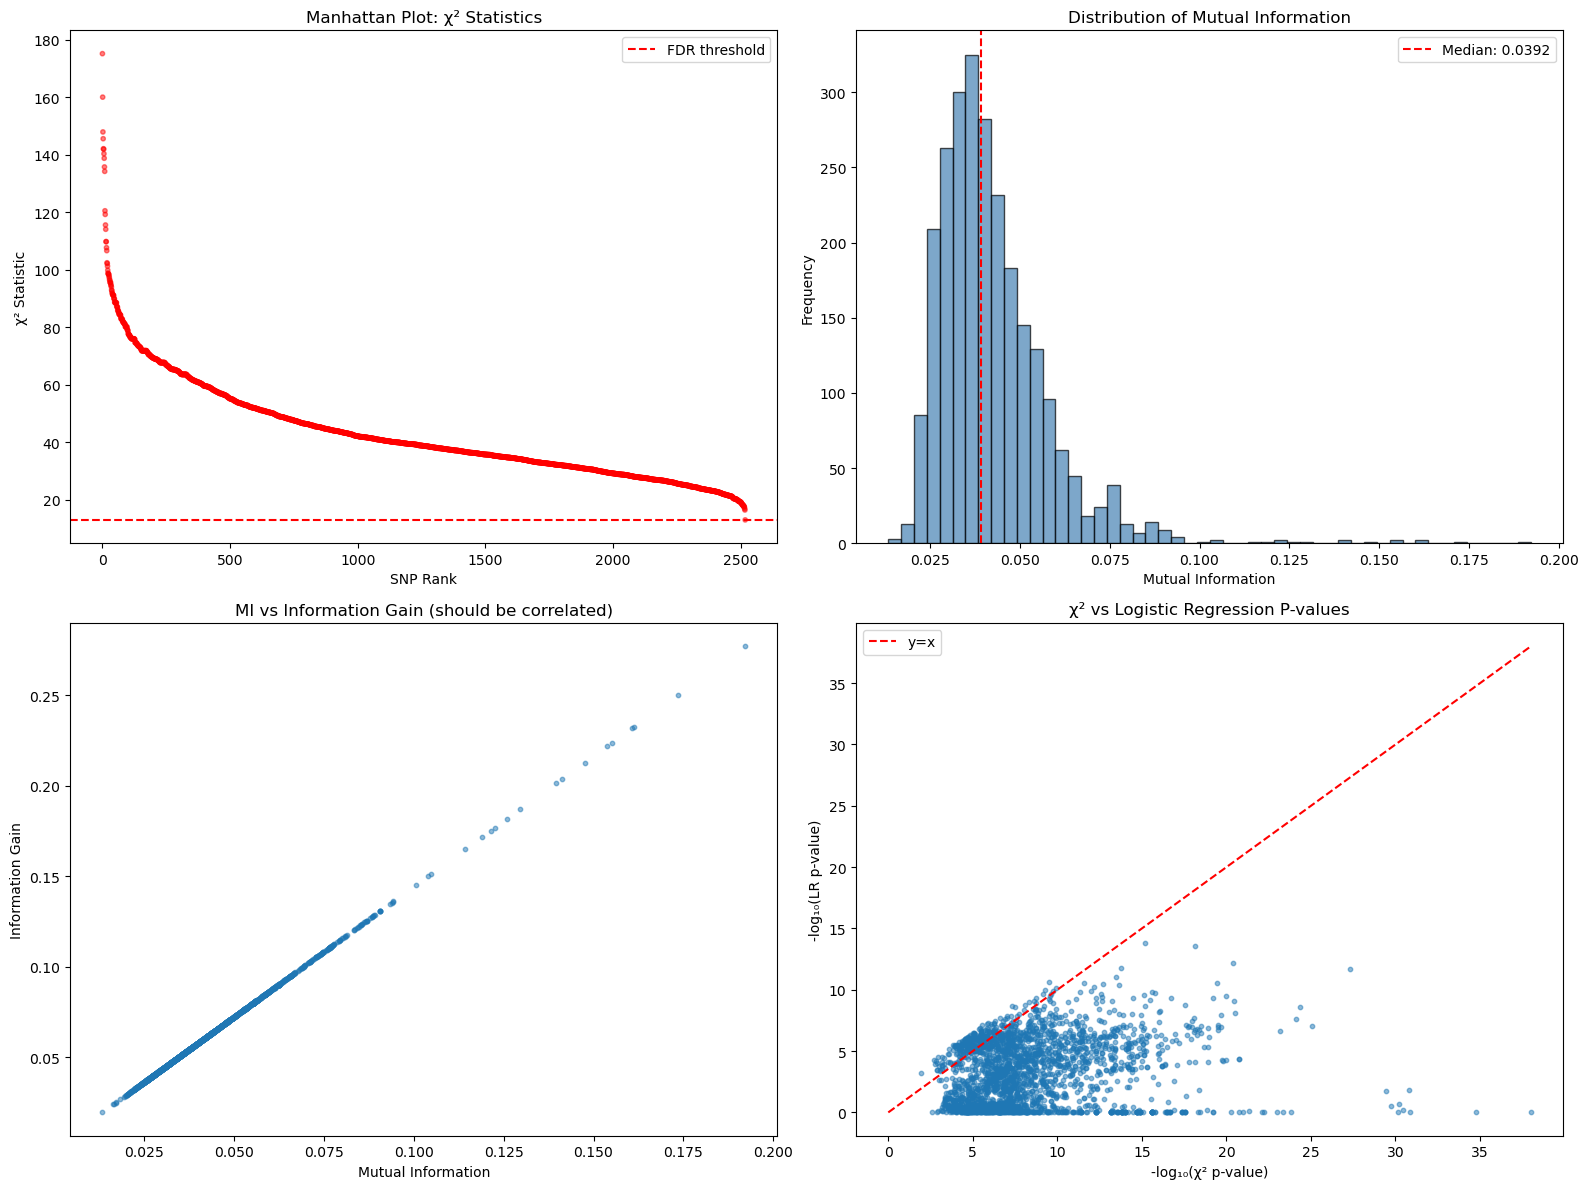

In [14]:
# Manhattan-style plot of χ² statistics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Manhattan-style χ² plot
ax = axes[0, 0]
sorted_chi2 = results_df.sort_values('chi2', ascending=False).reset_index(drop=True)
colors = ['red' if sig else 'steelblue' for sig in sorted_chi2['chi2_significant_fdr']]
ax.scatter(range(len(sorted_chi2)), sorted_chi2['chi2'], c=colors, alpha=0.5, s=10)
ax.axhline(sorted_chi2[sorted_chi2['chi2_significant_fdr']]['chi2'].min() if sorted_chi2['chi2_significant_fdr'].any() else 0, 
           color='red', linestyle='--', label='FDR threshold')
ax.set_xlabel('SNP Rank')
ax.set_ylabel('χ² Statistic')
ax.set_title('Manhattan Plot: χ² Statistics')
ax.legend()

# Plot 2: Histogram of Mutual Information
ax = axes[0, 1]
ax.hist(results_df['mutual_information'].dropna(), bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax.axvline(results_df['mutual_information'].median(), color='red', linestyle='--', label=f'Median: {results_df["mutual_information"].median():.4f}')
ax.set_xlabel('Mutual Information')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Mutual Information')
ax.legend()

# Plot 3: Information Gain vs Mutual Information
ax = axes[1, 0]
ax.scatter(results_df['mutual_information'], results_df['information_gain'], alpha=0.5, s=10)
ax.set_xlabel('Mutual Information')
ax.set_ylabel('Information Gain')
ax.set_title('MI vs Information Gain (should be correlated)')

# Plot 4: -log10(p-value) comparison
ax = axes[1, 1]
log_chi2_p = -np.log10(results_df['chi2_pvalue'].clip(lower=1e-300))
log_lr_p = -np.log10(results_df['lr_pvalue'].clip(lower=1e-300))
ax.scatter(log_chi2_p, log_lr_p, alpha=0.5, s=10)
ax.plot([0, max(log_chi2_p.max(), log_lr_p.max())], [0, max(log_chi2_p.max(), log_lr_p.max())], 'r--', label='y=x')
ax.set_xlabel('-log₁₀(χ² p-value)')
ax.set_ylabel('-log₁₀(LR p-value)')
ax.set_title('χ² vs Logistic Regression P-values')
ax.legend()

plt.tight_layout()
plt.show()

In [15]:
# Ranking table of top 50 SNPs
print("="*80)
print("TOP 50 ANCESTRY-INFORMATIVE SNPs (Ranked by Mutual Information)")
print("="*80)

top_50 = results_df.nlargest(50, 'mutual_information')[[
    'snp_id', 'chi2', 'chi2_pvalue', 'mutual_information', 
    'information_gain', 'kl_divergence', 'lr_pseudo_r2'
]].copy()

top_50['rank'] = range(1, 51)
top_50 = top_50[['rank', 'snp_id', 'chi2', 'chi2_pvalue', 'mutual_information', 
                  'information_gain', 'kl_divergence', 'lr_pseudo_r2']]

display(top_50)

TOP 50 ANCESTRY-INFORMATIVE SNPs (Ranked by Mutual Information)


,rank,snp_id,chi2,chi2_pvalue,mutual_information,information_gain,kl_divergence,lr_pseudo_r2
961,1,4:17813761,175.081948,9.581602e-39,0.192157,0.277224,3.878612,0.181527
1116,2,1:12387655,159.962062,1.839414e-35,0.173566,0.250402,3.868477,0.163964
2347,3,19:54792079,147.862669,5.843766e-31,0.161159,0.232503,0.557670,0.151884
2407,4,14:96938945,138.716937,7.550918e-31,0.160640,0.231754,2.856275,0.151752
1574,5,5:41181491,142.028434,1.441841e-31,0.155135,0.223812,3.279970,0.146553
1129,6,1:22315762,145.506558,1.868244e-30,0.153762,0.221832,0.659853,0.145251
148,7,3:86028382,141.850420,1.576060e-31,0.147565,0.212892,0.377273,0.139402
269,8,21:38533017,140.276518,3.462112e-31,0.141221,0.203739,0.411417,0.133408
1534,9,9:133578385,135.694906,3.421571e-30,0.139555,0.201336,0.531534,0.131835
192,10,3:152553769,115.513595,8.251665e-26,0.129657,0.187056,0.563399,0.122484


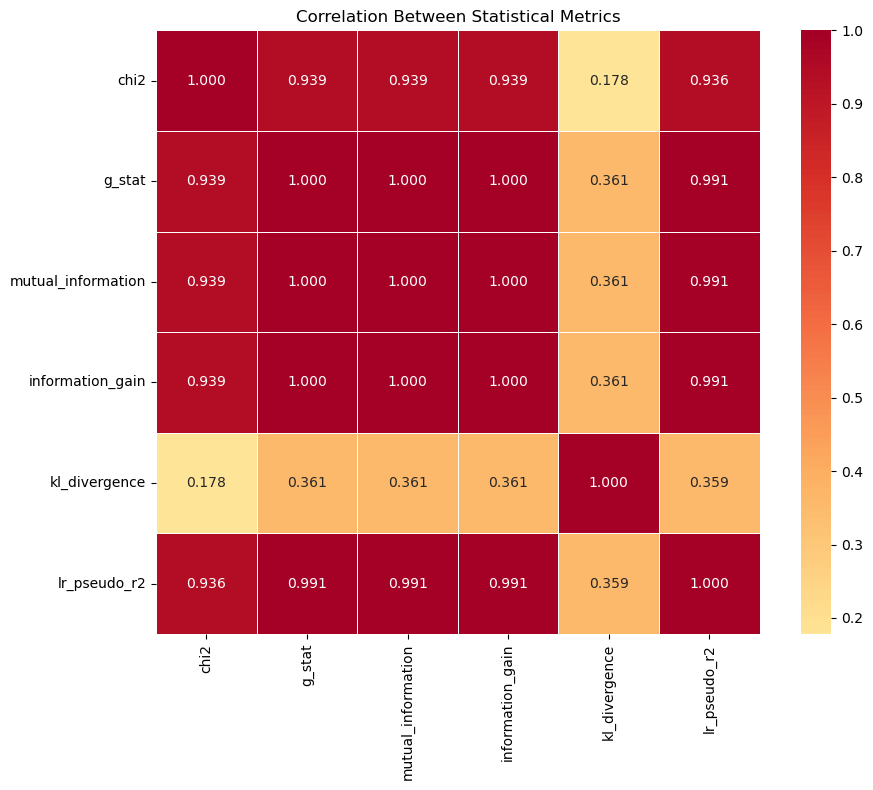

In [16]:
# Correlation heatmap between different metrics
metric_cols = ['chi2', 'g_stat', 'mutual_information', 'information_gain', 
               'kl_divergence', 'lr_pseudo_r2']

corr_matrix = results_df[metric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='RdYlBu_r', center=0, 
            fmt='.3f', square=True, linewidths=0.5)
plt.title('Correlation Between Statistical Metrics')
plt.tight_layout()
plt.show()

In [17]:
# Venn-style analysis: SNPs significant across multiple tests
from collections import Counter

# Define significance criteria for each test
sig_chi2 = set(results_df[results_df['chi2_significant_fdr']]['snp_id'])
sig_mi = set(results_df.nlargest(500, 'mutual_information')['snp_id'])  # Top 500 by MI
sig_ig = set(results_df.nlargest(500, 'information_gain')['snp_id'])  # Top 500 by IG
sig_kl = set(results_df.nlargest(500, 'kl_divergence')['snp_id'])  # Top 500 by KL

print("SNP Overlap Analysis:")
print("="*60)
print(f"Significant by χ² (FDR < 0.05): {len(sig_chi2)}")
print(f"Top 500 by MI: {len(sig_mi)}")
print(f"Top 500 by IG: {len(sig_ig)}")
print(f"Top 500 by KL: {len(sig_kl)}")

# Find SNPs significant in multiple tests
all_sig_snps = list(sig_chi2) + list(sig_mi) + list(sig_ig) + list(sig_kl)
snp_counts = Counter(all_sig_snps)

snps_in_4 = [s for s, c in snp_counts.items() if c == 4]
snps_in_3 = [s for s, c in snp_counts.items() if c >= 3]
snps_in_2 = [s for s, c in snp_counts.items() if c >= 2]

print(f"\nSNPs significant in:")
print(f"  All 4 tests: {len(snps_in_4)}")
print(f"  ≥3 tests: {len(snps_in_3)}")
print(f"  ≥2 tests: {len(snps_in_2)}")

SNP Overlap Analysis:
Significant by χ² (FDR < 0.05): 2518
Top 500 by MI: 500
Top 500 by IG: 500
Top 500 by KL: 500

SNPs significant in:
  All 4 tests: 205
  ≥3 tests: 498
  ≥2 tests: 797


## 5.5 PCA Analysis on Top Statistical SNPs

Perform Principal Component Analysis (PCA) to visualize population clustering using SNPs selected by statistical tests.

- **Full dataset**: PCA on all SNPs
- **Top SNPs**: PCA on consensus SNPs (significant in multiple tests)
- **Comparison**: How well do statistically-selected SNPs separate populations?

In [18]:
# PCA imports
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Prepare data for PCA
X_all = genotypes.values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_all)

# PCA on all SNPs
pca_all = PCA(n_components=3)
pca_all_result = pca_all.fit_transform(X_scaled)

print("PCA on All SNPs:")
print(f"  Number of features: {X_all.shape[1]}")
print(f"  Explained variance ratio: {pca_all.explained_variance_ratio_}")
print(f"  Total variance explained (3 PCs): {sum(pca_all.explained_variance_ratio_):.4f}")

PCA on All SNPs:
  Number of features: 2518
  Explained variance ratio: [0.0685108  0.02560354 0.02059285]
  Total variance explained (3 PCs): 0.1147


In [20]:
# PCA on consensus SNPs (significant in multiple tests)
# Get SNPs that are in our dataset
consensus_snps_available = [s for s in snps_in_4 if s in snp_columns]

# If not enough SNPs in all 4, use ≥3 tests
if len(consensus_snps_available) < 25:
    consensus_snps_available = [s for s in snps_in_3 if s in snp_columns]
    consensus_label = "≥3 tests"
else:
    consensus_label = "all 4 tests"

print(f"Consensus SNPs available ({consensus_label}): {len(consensus_snps_available)}")

# Also get top 100 SNPs by mutual information
top_100_mi = results_df.sort_values('mutual_information', ascending=False).head(100)['snp_id'].tolist()
top_100_available = [s for s in top_100_mi if s in snp_columns]
print(f"Top 100 MI SNPs available: {len(top_100_available)}")

# PCA on consensus SNPs
if len(consensus_snps_available) >= 10:
    X_consensus = genotypes[consensus_snps_available].values
    X_consensus_scaled = scaler.fit_transform(X_consensus)
    pca_consensus = PCA(n_components=3)
    pca_consensus_result = pca_consensus.fit_transform(X_consensus_scaled)
    print(f"\nPCA on Consensus SNPs ({len(consensus_snps_available)} features):")
    print(f"  Explained variance: {pca_consensus.explained_variance_ratio_}")
    print(f"  Total (3 PCs): {sum(pca_consensus.explained_variance_ratio_):.4f}")
else:
    print("Not enough consensus SNPs for PCA")
    pca_consensus_result = None

# PCA on top 100 MI SNPs
X_top100 = genotypes[top_100_available].values
X_top100_scaled = scaler.fit_transform(X_top100)
pca_top100 = PCA(n_components=3)
pca_top100_result = pca_top100.fit_transform(X_top100_scaled)
print(f"\nPCA on Top 100 MI SNPs:")
print(f"  Explained variance: {pca_top100.explained_variance_ratio_}")
print(f"  Total (3 PCs): {sum(pca_top100.explained_variance_ratio_):.4f}")

Consensus SNPs available (all 4 tests): 205
Top 100 MI SNPs available: 100

PCA on Consensus SNPs (205 features):
  Explained variance: [0.17698877 0.07666535 0.04843475]
  Total (3 PCs): 0.3021

PCA on Top 100 MI SNPs:
  Explained variance: [0.20667147 0.10353458 0.06088581]
  Total (3 PCs): 0.3711


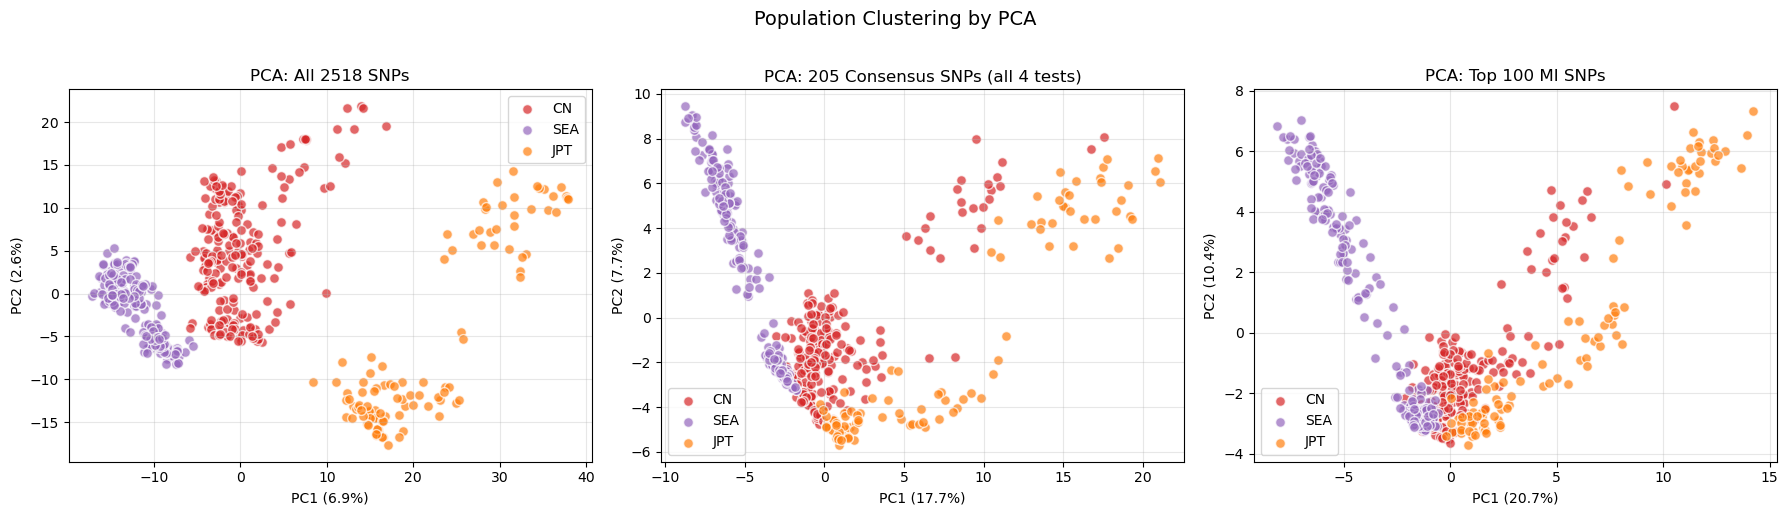

In [22]:
# Create PCA visualization - 2D plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Color palette for populations (distinct colors for CN, SEA, JPT, etc.)
pop_unique = populations.unique()
colors = {
    'CHB': '#1f77b4',   # Blue
    'JPT': '#ff7f0e',   # Orange
    'KHV': '#2ca02c',   # Green
    'CN': '#d62728',    # Red
    'SEA': '#9467bd',   # Purple
    'CHN': '#e377c2',   # Pink
}
pop_colors = [colors.get(p, 'gray') for p in populations]

# Plot 1: All SNPs
ax = axes[0]
for pop in pop_unique:
    mask = populations == pop
    ax.scatter(pca_all_result[mask, 0], pca_all_result[mask, 1], 
               c=colors.get(pop, 'gray'), label=pop, alpha=0.7, s=50, edgecolors='white')
ax.set_xlabel(f'PC1 ({pca_all.explained_variance_ratio_[0]*100:.1f}%)')
ax.set_ylabel(f'PC2 ({pca_all.explained_variance_ratio_[1]*100:.1f}%)')
ax.set_title(f'PCA: All {len(snp_columns)} SNPs')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Consensus SNPs
ax = axes[1]
if pca_consensus_result is not None:
    for pop in pop_unique:
        mask = populations == pop
        ax.scatter(pca_consensus_result[mask, 0], pca_consensus_result[mask, 1], 
                   c=colors.get(pop, 'gray'), label=pop, alpha=0.7, s=50, edgecolors='white')
    ax.set_xlabel(f'PC1 ({pca_consensus.explained_variance_ratio_[0]*100:.1f}%)')
    ax.set_ylabel(f'PC2 ({pca_consensus.explained_variance_ratio_[1]*100:.1f}%)')
    ax.set_title(f'PCA: {len(consensus_snps_available)} Consensus SNPs ({consensus_label})')
    ax.legend()
    ax.grid(True, alpha=0.3)
else:
    ax.text(0.5, 0.5, 'Not enough consensus SNPs', ha='center', va='center', transform=ax.transAxes)
    ax.set_title('PCA: Consensus SNPs (N/A)')

# Plot 3: Top 100 MI SNPs
ax = axes[2]
for pop in pop_unique:
    mask = populations == pop
    ax.scatter(pca_top100_result[mask, 0], pca_top100_result[mask, 1], 
               c=colors.get(pop, 'gray'), label=pop, alpha=0.7, s=50, edgecolors='white')
ax.set_xlabel(f'PC1 ({pca_top100.explained_variance_ratio_[0]*100:.1f}%)')
ax.set_ylabel(f'PC2 ({pca_top100.explained_variance_ratio_[1]*100:.1f}%)')
ax.set_title(f'PCA: Top {len(top_100_available)} MI SNPs')
ax.legend()
ax.grid(True, alpha=0.3)

plt.suptitle('Population Clustering by PCA', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

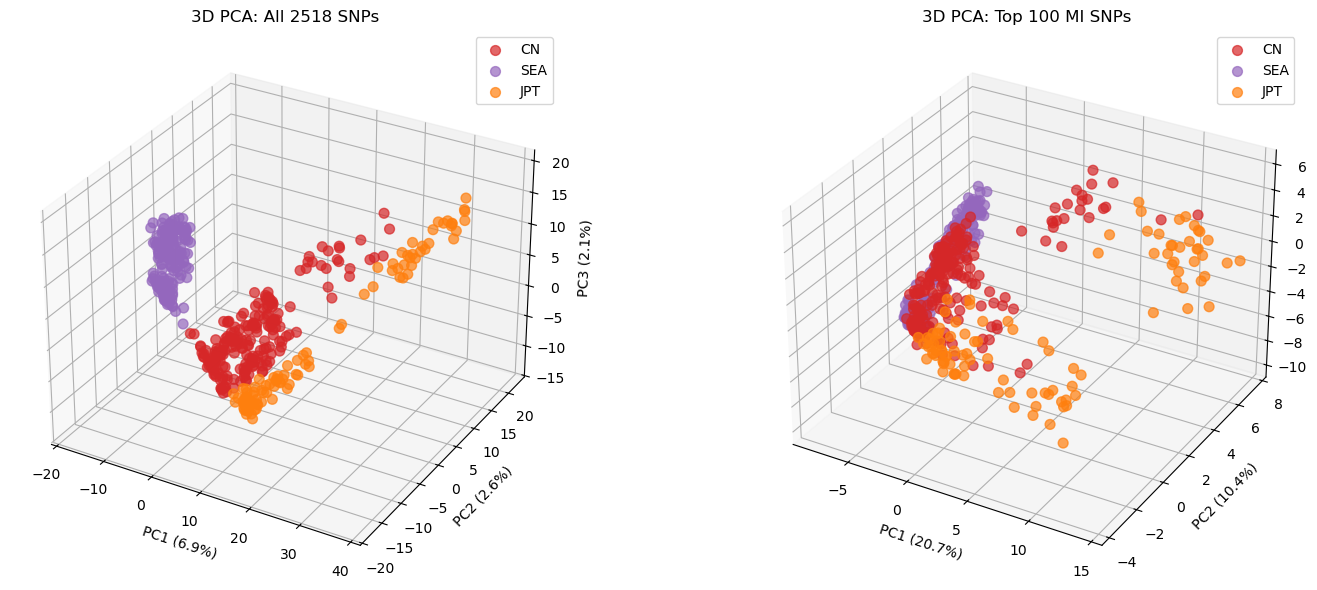

In [23]:
# 3D PCA visualization
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(16, 6))

# 3D Plot 1: All SNPs
ax = fig.add_subplot(121, projection='3d')
for pop in pop_unique:
    mask = populations == pop
    ax.scatter(pca_all_result[mask, 0], pca_all_result[mask, 1], pca_all_result[mask, 2],
               c=colors.get(pop, 'gray'), label=pop, alpha=0.7, s=50)
ax.set_xlabel(f'PC1 ({pca_all.explained_variance_ratio_[0]*100:.1f}%)')
ax.set_ylabel(f'PC2 ({pca_all.explained_variance_ratio_[1]*100:.1f}%)')
ax.set_zlabel(f'PC3 ({pca_all.explained_variance_ratio_[2]*100:.1f}%)')
ax.set_title(f'3D PCA: All {len(snp_columns)} SNPs')
ax.legend()

# 3D Plot 2: Top 100 MI SNPs
ax = fig.add_subplot(122, projection='3d')
for pop in pop_unique:
    mask = populations == pop
    ax.scatter(pca_top100_result[mask, 0], pca_top100_result[mask, 1], pca_top100_result[mask, 2],
               c=colors.get(pop, 'gray'), label=pop, alpha=0.7, s=50)
ax.set_xlabel(f'PC1 ({pca_top100.explained_variance_ratio_[0]*100:.1f}%)')
ax.set_ylabel(f'PC2 ({pca_top100.explained_variance_ratio_[1]*100:.1f}%)')
ax.set_zlabel(f'PC3 ({pca_top100.explained_variance_ratio_[2]*100:.1f}%)')
ax.set_title(f'3D PCA: Top {len(top_100_available)} MI SNPs')
ax.legend()

plt.tight_layout()
plt.show()

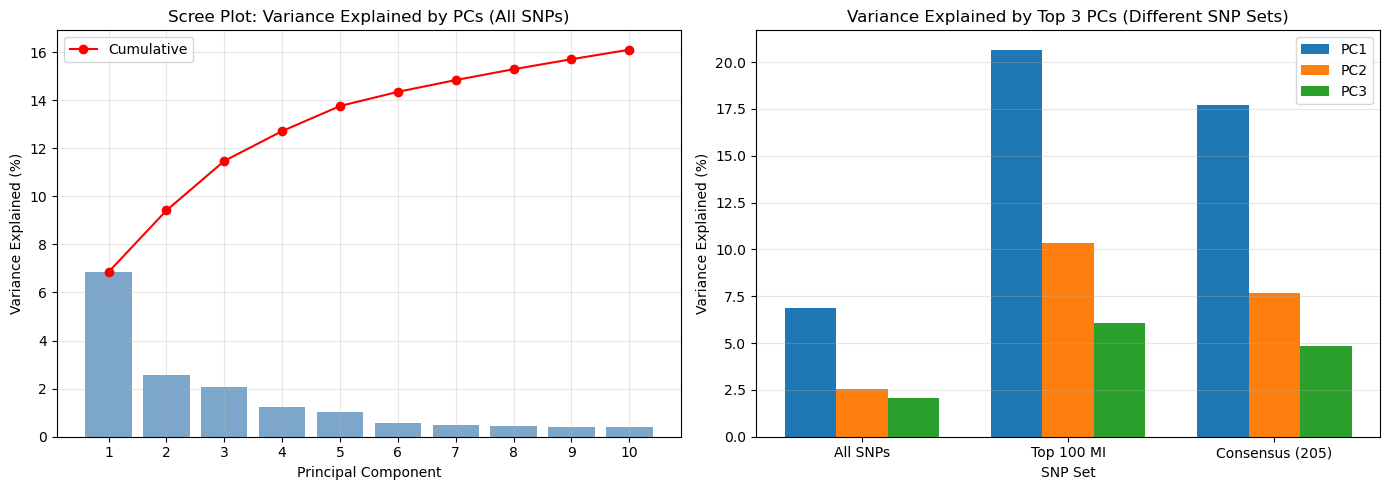


Variance Explained Summary:
------------------------------------------------------------
All SNPs (2518): PC1=6.85%, PC2=2.56%, PC3=2.06%
Top 100 MI: PC1=20.67%, PC2=10.35%, PC3=6.09%
Consensus (205): PC1=17.70%, PC2=7.67%, PC3=4.84%


In [24]:
# Scree plot and variance explained comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scree plot - full PCA with more components
pca_full = PCA(n_components=10)
pca_full.fit(X_scaled)

ax = axes[0]
ax.bar(range(1, 11), pca_full.explained_variance_ratio_ * 100, color='steelblue', alpha=0.7)
ax.plot(range(1, 11), np.cumsum(pca_full.explained_variance_ratio_) * 100, 'ro-', label='Cumulative')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Variance Explained (%)')
ax.set_title('Scree Plot: Variance Explained by PCs (All SNPs)')
ax.set_xticks(range(1, 11))
ax.legend()
ax.grid(True, alpha=0.3)

# Comparison: Variance explained by different SNP sets
ax = axes[1]
datasets = ['All SNPs', 'Top 100 MI']
pc1_var = [pca_all.explained_variance_ratio_[0] * 100, pca_top100.explained_variance_ratio_[0] * 100]
pc2_var = [pca_all.explained_variance_ratio_[1] * 100, pca_top100.explained_variance_ratio_[1] * 100]
pc3_var = [pca_all.explained_variance_ratio_[2] * 100, pca_top100.explained_variance_ratio_[2] * 100]

if pca_consensus_result is not None:
    datasets.append(f'Consensus ({len(consensus_snps_available)})')
    pc1_var.append(pca_consensus.explained_variance_ratio_[0] * 100)
    pc2_var.append(pca_consensus.explained_variance_ratio_[1] * 100)
    pc3_var.append(pca_consensus.explained_variance_ratio_[2] * 100)

x = np.arange(len(datasets))
width = 0.25

ax.bar(x - width, pc1_var, width, label='PC1', color='#1f77b4')
ax.bar(x, pc2_var, width, label='PC2', color='#ff7f0e')
ax.bar(x + width, pc3_var, width, label='PC3', color='#2ca02c')
ax.set_xlabel('SNP Set')
ax.set_ylabel('Variance Explained (%)')
ax.set_title('Variance Explained by Top 3 PCs (Different SNP Sets)')
ax.set_xticks(x)
ax.set_xticklabels(datasets)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nVariance Explained Summary:")
print("-" * 60)
print(f"All SNPs ({len(snp_columns)}): PC1={pc1_var[0]:.2f}%, PC2={pc2_var[0]:.2f}%, PC3={pc3_var[0]:.2f}%")
print(f"Top 100 MI: PC1={pc1_var[1]:.2f}%, PC2={pc2_var[1]:.2f}%, PC3={pc3_var[1]:.2f}%")
if len(datasets) > 2:
    print(f"Consensus ({len(consensus_snps_available)}): PC1={pc1_var[2]:.2f}%, PC2={pc2_var[2]:.2f}%, PC3={pc3_var[2]:.2f}%")

In [25]:
# Population centroid distances in PCA space
from scipy.spatial.distance import pdist, squareform

def calculate_population_separation(pca_result, populations):
    """Calculate mean distance between population centroids in PCA space."""
    pop_unique = populations.unique()
    centroids = {}
    
    for pop in pop_unique:
        mask = populations == pop
        centroids[pop] = pca_result[mask].mean(axis=0)
    
    # Calculate pairwise distances between centroids
    centroid_matrix = np.array([centroids[p] for p in pop_unique])
    distances = squareform(pdist(centroid_matrix))
    
    # Mean distance (excluding diagonal)
    n = len(pop_unique)
    mean_dist = distances.sum() / (n * (n - 1))
    
    return mean_dist, distances, pop_unique

# Calculate separation for each SNP set
sep_all, dist_all, pops = calculate_population_separation(pca_all_result, populations)
sep_top100, dist_top100, _ = calculate_population_separation(pca_top100_result, populations)

print("Population Separation in PCA Space (Centroid Distances):")
print("=" * 60)
print(f"\nAll SNPs ({len(snp_columns)}):")
print(f"  Mean centroid distance: {sep_all:.4f}")
print(f"  Pairwise distances:")
for i, p1 in enumerate(pops):
    for j, p2 in enumerate(pops):
        if i < j:
            print(f"    {p1} - {p2}: {dist_all[i, j]:.4f}")

print(f"\nTop 100 MI SNPs:")
print(f"  Mean centroid distance: {sep_top100:.4f}")
print(f"  Pairwise distances:")
for i, p1 in enumerate(pops):
    for j, p2 in enumerate(pops):
        if i < j:
            print(f"    {p1} - {p2}: {dist_top100[i, j]:.4f}")

if pca_consensus_result is not None:
    sep_consensus, dist_consensus, _ = calculate_population_separation(pca_consensus_result, populations)
    print(f"\nConsensus SNPs ({len(consensus_snps_available)}):")
    print(f"  Mean centroid distance: {sep_consensus:.4f}")
    print(f"  Pairwise distances:")
    for i, p1 in enumerate(pops):
        for j, p2 in enumerate(pops):
            if i < j:
                print(f"    {p1} - {p2}: {dist_consensus[i, j]:.4f}")

Population Separation in PCA Space (Centroid Distances):

All SNPs (2518):
  Mean centroid distance: 26.1285
  Pairwise distances:
    CN - SEA: 18.6056
    CN - JPT: 25.9606
    SEA - JPT: 33.8193

Top 100 MI SNPs:
  Mean centroid distance: 7.3219
  Pairwise distances:
    CN - SEA: 5.7007
    CN - JPT: 6.4949
    SEA - JPT: 9.7701

Consensus SNPs (205):
  Mean centroid distance: 8.9335
  Pairwise distances:
    CN - SEA: 6.7664
    CN - JPT: 7.3865
    SEA - JPT: 12.6476


## 6. Save Results

In [26]:
# Sort results by mutual information
results_df_sorted = results_df.sort_values('mutual_information', ascending=False)

# Filter for SNPs passing ALL 4 tests
results_df['tests_passed'] = results_df['snp_id'].apply(lambda x: snp_counts.get(x, 0))
results_df_all4 = results_df[results_df['tests_passed'] == 4].copy()
results_df_all4_sorted = results_df_all4.sort_values('mutual_information', ascending=False)

print(f"SNPs passing ALL 4 tests: {len(results_df_all4_sorted)}")

# Save full results
output_path = str(PATHS.OUTPUT_DIR / "statistics_snp_scores.csv")
results_df_sorted.to_csv(output_path, index=False)
print(f"Full results saved to: {output_path}")

# Save SNPs that passed ALL 4 tests (primary output)
all4_snps_path = str(PATHS.OUTPUT_DIR / "statistical_all4_snps_03b.csv")
results_df_all4_sorted.to_csv(all4_snps_path, index=False)
print(f"SNPs passing all 4 tests saved: {all4_snps_path} ({len(results_df_all4_sorted)} SNPs)")

# Save SNP IDs only for downstream use
all4_ids_path = str(PATHS.OUTPUT_DIR / "statistical_all4_snp_ids_03b.txt")
results_df_all4_sorted[['snp_id']].to_csv(all4_ids_path, index=False, header=False)
print(f"All-4-tests SNP IDs saved: {all4_ids_path}")

# Save ML data with ONLY all-4-tests SNPs (memory efficient for downstream ML)
all4_snp_ids = results_df_all4_sorted['snp_id'].tolist()
available_all4_snps = [s for s in all4_snp_ids if s in snp_columns]
ml_cols = ['sample', 'pop'] + available_all4_snps
ml_data_all4 = df[ml_cols]

ml_data_path = str(PATHS.OUTPUT_DIR / "statistical_ml_data_03b.csv")
ml_data_all4.to_csv(ml_data_path, index=False)
print(f"ML data (all-4-tests SNPs only) saved: {ml_data_path}")
print(f"  → {len(available_all4_snps)} SNPs, {len(ml_data_all4)} samples")

# Also save top 500 for backward compatibility
top_500 = results_df_sorted.head(500)
top500_path = str(PATHS.OUTPUT_DIR / "top500_statistical_snps.csv")
top_500.to_csv(top500_path, index=False)
print(f"Top 500 SNPs saved to: {top500_path}")

SNPs passing ALL 4 tests: 205
Full results saved to: 1000genomes/output_sea_jpt_cn/statistics_snp_scores.csv
SNPs passing all 4 tests saved: 1000genomes/output_sea_jpt_cn/statistical_all4_snps_03b.csv (205 SNPs)
All-4-tests SNP IDs saved: 1000genomes/output_sea_jpt_cn/statistical_all4_snp_ids_03b.txt
ML data (all-4-tests SNPs only) saved: 1000genomes/output_sea_jpt_cn/statistical_ml_data_03b.csv
  → 205 SNPs, 504 samples
Top 500 SNPs saved to: 1000genomes/output_sea_jpt_cn/top500_statistical_snps.csv


## Summary

This notebook performed comprehensive statistical analysis on SNPs for ancestry inference.

In [27]:
print("="*70)
print("STATISTICAL SNP ANALYSIS SUMMARY")
print("="*70)
print(f"\nDataset:")
print(f"  Samples: {len(df)}")
print(f"  SNPs analyzed: {len(snp_columns)}")
print(f"  Populations: {list(populations.unique())}")

print(f"\nStatistical Tests Performed:")
print(f"  1. Pearson χ² test")
print(f"  2. G-test (likelihood ratio)")
print(f"  3. Fisher's exact test")
print(f"  4. Mutual Information")
print(f"  5. Information Gain")
print(f"  6. KL Divergence")
print(f"  7. Multinomial Logistic Regression")

print(f"\nFiltering Results:")
print(f"  χ² (FDR < 0.05): {results_df['chi2_significant_fdr'].sum()}")
print(f"  LR (FDR < 0.05): {results_df['lr_significant_fdr'].sum()}")
print(f"  Overlap (≥3 tests): {len(snps_in_3)}")
print(f"  ★ Passed ALL 4 tests: {len(snps_in_4)}")

if len(results_df_all4_sorted) > 0:
    print(f"\nTop SNP (All 4 Tests) by Mutual Information:")
    top_snp = results_df_all4_sorted.iloc[0]
    print(f"  {top_snp['snp_id']}")
    print(f"  MI: {top_snp['mutual_information']:.6f}")
    print(f"  χ²: {top_snp['chi2']:.2f} (p={top_snp['chi2_pvalue']:.2e})")

print(f"\nOutput Files:")
print(f"  - statistics_snp_scores.csv (all results)")
print(f"  - statistical_all4_snps_03b.csv ({len(results_df_all4_sorted)} SNPs passing all 4 tests) ★")
print(f"  - statistical_all4_snp_ids_03b.txt (IDs for PLINK) ★")
print(f"  - statistical_ml_data_03b.csv (ML-ready data with all-4 SNPs only) ★")
print(f"  - top500_statistical_snps.csv (top 500 SNPs)")

print(f"\nNext Steps:")
print(f"  - Use statistical_ml_data_03b.csv for ML training (memory efficient)")
print(f"  - Compare with FST-selected SNPs (03_fst_and_pca.ipynb)")
print(f"  - Use consensus SNPs for final ancestry inference model")

STATISTICAL SNP ANALYSIS SUMMARY

Dataset:
  Samples: 504
  SNPs analyzed: 2518
  Populations: ['CN', 'SEA', 'JPT']

Statistical Tests Performed:
  1. Pearson χ² test
  2. G-test (likelihood ratio)
  3. Fisher's exact test
  4. Mutual Information
  5. Information Gain
  6. KL Divergence
  7. Multinomial Logistic Regression

Filtering Results:
  χ² (FDR < 0.05): 2518
  LR (FDR < 0.05): 1615
  Overlap (≥3 tests): 498
  ★ Passed ALL 4 tests: 205

Top SNP (All 4 Tests) by Mutual Information:
  4:17813761
  MI: 0.192157
  χ²: 175.08 (p=9.58e-39)

Output Files:
  - statistics_snp_scores.csv (all results)
  - statistical_all4_snps_03b.csv (205 SNPs passing all 4 tests) ★
  - statistical_all4_snp_ids_03b.txt (IDs for PLINK) ★
  - statistical_ml_data_03b.csv (ML-ready data with all-4 SNPs only) ★
  - top500_statistical_snps.csv (top 500 SNPs)

Next Steps:
  - Use statistical_ml_data_03b.csv for ML training (memory efficient)
  - Compare with FST-selected SNPs (03_fst_and_pca.ipynb)
  - Use cons